# 🛸프로젝트 목표
- 직접 선택한 데이터셋을 사용해서 만든 머신러닝 예측 모델을 통한 성능 및 인사이트를 도출/공유하는 것이 목표
- 데이터셋을 사용하여 머신러능 모델을 만든 후 성능 및 인사이트를 도출 / 공유하는 것
	을 데이터셋 선정부터 모델 해석까지의 결과로 보여주는 것이 목표
    
- 발표를 듣는 사람은 비데이터 직군이라 가정합니다.
  생각이나 가정들을 설명하는 과정에서 최대한 배경지식이 없는 사람들도 이해할 수 있도록 노력

## 1) 데이터 선정 이유 및 문제 정의

- 데이터 선정이유 : 해당 게임의 데이터를 선정한 것은 오랫동안 플레이해온 유저로써 관심이 있어 선정하였고 다른 데이터셋 중에서 다이아1이상 티어게임의 초반 10분간의 데이터만 존재하는 데이터셋을 선택한 것은 LoL이라는 게임은 초반에 snowballing(이득을 쌓아가는 것)이 중요한 게임이고 상위티어 게임일수록 그 영향력이 커지기때문에 유의미한 결과를 얻을 수 있을 것 같아 선택하였습니다.

- 유형 : 승리와 패배(1,0)로 나누어진 타겟을 선택하여 분류문제로 접근하였습니다.

#### 데이터 설명
- gameId : 게임의 고유 ID
- blueWins : 승리 여부(1,0)
>- blueWardsPlaced : 설치 와드 수
>- blueWardsDestroyed : 블루팀이 파괴한 적 와드 수
>- blueFirstBlood : 첫 킬(블루:1, 레드:0)
>- blueKills : 블루팀이 죽인 적의 수
>- blueDeaths : 블루팀이 죽은 수
>- blueAssists : 블루팀의 어시스트 수
>- blueEliteMonsters : 블루팀이 죽인 엘리트몬스터 수
>- blueDragons : 블루팀이 죽인 드래곤 수(1,0)
>- blueHeralds : 블루팀이 죽인 전령(1,0)
>- blueTowersDestroyed : 블루팀이 파괴한 타워 수
>- blueTotalGold : 블루팀 총 골드획득량
>- blueAvgLevel : 블루팀 평균 챔피언 레벨
>- blueTotalExperience : 블루팀 총 경험치량
>- blueTotalMinionsKilled : 블루팀 총 미니언 처치 수
>- blueTotalJungleMinionsKilled : 블루팀 총 정글몬스터 처치 수
>- blueGoldDiff : 블루팀과 적팀의 골드 차이
>- blueExperienceDiff : 블루팀과 적팀의 경험치 차이
>- blueCSPerMin : 블루팀의 분당 미니언 처치 수
>- blueGoldPerMin : 블루팀의 분당 팀 골드획득량
- red도 동일한 19개의 feature 존재

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
target = 'blueWins'      # 타겟 설정(승리)

# league of legend게임 data(다이아1티어 이상게임, 초반10분간의 게임내용)
df = pd.read_csv('C:\\Users\\Yong\\코드스테이츠 AI\\N23x\\archive\\high_diamond_ranked_10min.csv')
df                       # 9879 x 40

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  \
0     4519157822         0               28                   2   
1     4523371949         0               12                   1   
2     4521474530         0               15                   0   
3     4524384067         0               43                   1   
4     4436033771         0               75                   4   
...          ...       ...              ...                 ...   
9874  4527873286         1               17                   2   
9875  4527797466         1               54                   0   
9876  4527713716         0               23                   1   
9877  4527628313         0               14                   4   
9878  4523772935         1               18                   0   

      blueFirstBlood  blueKills  blueDeaths  blueAssists  blueEliteMonsters  \
0                  1          9           6           11                  0   
1                  0          5           5            5                  0   
2                  0          7          11            4                  1   
3                  0          4           5            5                  1   
4                  0          6           6            6                  0   
...              ...        ...         ...          ...                ...   
9874               1          7           4            5                  1   
9875               0          6           4            8                  1   
9876               0          6           7            5                  0   
9877               1          2           3            3                  1   
9878               1          6           6            5                  0   

      blueDragons  ...  redTowersDestroyed  redTotalGold  redAvgLevel  \
0               0  ...                   0         16567          6.8   
1               0  ...                   1         17620          6.8   
2               1  ...                   0         17285          6.8   
3               0  ...                   0         16478          7.0   
4               0  ...                   0         17404          7.0   
...           ...  ...                 ...           ...          ...   
9874            1  ...                   0         15246          6.8   
9875            1  ...                   0         15456          7.0   
9876            0  ...                   0         18319          7.4   
9877            1  ...                   0         15298          7.2   
9878            0  ...                   0         15339          6.8   

      redTotalExperience  redTotalMinionsKilled  redTotalJungleMinionsKilled  \
0                  17047                    197                           55   
1                  17438                    240                           52   
2                  17254                    203                           28   
3                  17961                    235                           47   
4                  18313                    225                           67   
...                  ...                    ...                          ...   
9874               16498                    229                           34   
9875               18367                    206                           56   
9876               19909                    261                           60   
9877               18314                    247                           40   
9878               17379                    201                           46   

      redGoldDiff  redExperienceDiff  redCSPerMin  redGoldPerMin  
0            -643                  8         19.7         1656.7  
1            2908               1173         24.0         1762.0  
2            1172               1033         20.3         1728.5  
3            1321                  7         23.5         1647.8  
4            1004               -230         22.5         1740.4  
...           ..

In [3]:
#pip install -U matplotlib

In [4]:
report_data = ProfileReport(df)
#report_data

## 2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

#### 승리했는데 패배했다고 예측한 경우(FP)와 패배했는데 승리했다고 예측한 경우(FN) 둘 다 중요하기에 precision과 recall값 한쪽에 가중치를 줄 필요는 없어보인다. -> F1 score 사용

#### 가설 : 각 게임에서의 플레이어들의 실력이 비슷하다고 가정

- 해당 특성을 target으로 지정한 이유를 설명하세요

- 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명하세요


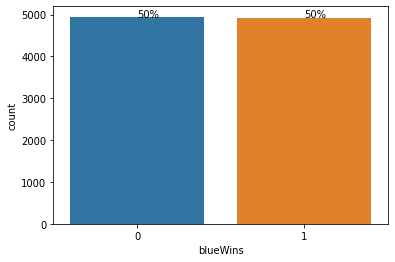

In [5]:
ax = sns.countplot(x='blueWins', data=df)
patch = ax.patches
half = int(len(patch)/2)
for i in range(half):
  pat_1= patch[i]
  pat_2 = patch[i+half]
  height_1 = pat_1.get_height()
  height_2 = pat_2.get_height()
  total = height_1  + height_2
  width_1 = pat_1.get_x()+pat_1.get_width()/2
  width_2 = pat_2.get_x()+pat_2.get_width()/2
  ax.text(width_1,height_1+1,"{:.0%}".format(height_1/total))
  ax.text(width_2,height_2+1,"{:.0%}".format(height_2/total))

In [6]:
baseline = df[target].value_counts(normalize=True) 
print(baseline)
#타겟 비율을 보니 accuracy를 적용해도 되겠다.

print("기준모델(승리):",baseline[1])

0    0.500962
1    0.499038
Name: blueWins, dtype: float64
기준모델(승리): 0.4990383642069035


### 평가지표 : 타겟의 클래스 분포가 5:5정도로 비슷하여 정확도(accuracy)를 사용하겠지만 분류문제의 다른평가지표들도 사용하여 검증해볼 예정
- Recall, Precision, F1_score, Roc_curve, AUC

In [7]:
# 가설 : 설치한 와드 수가 승리에 영향이 있을까?

## 3) EDA와 데이터 전처리

- Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?

- 이용욱님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?

In [8]:
df.info()                                          # object형이 없음, non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [9]:
df.duplicated().sum()                                 # 중복치 X

0

In [10]:
pd.options.display.float_format = '{:.5f}'.format     # 과학적 표기 to float

df.describe(include='all').T                          # 이상치 발견 >> 제거 필요

count             mean            std  \
gameId                       9879.00000 4500084044.84553 27573278.49092   
blueWins                     9879.00000          0.49904        0.50002   
blueWardsPlaced              9879.00000         22.28829       18.01918   
blueWardsDestroyed           9879.00000          2.82488        2.17500   
blueFirstBlood               9879.00000          0.50481        0.50000   
blueKills                    9879.00000          6.18393        3.01103   
blueDeaths                   9879.00000          6.13767        2.93382   
blueAssists                  9879.00000          6.64511        4.06452   
blueEliteMonsters            9879.00000          0.54995        0.62553   
blueDragons                  9879.00000          0.36198        0.48060   
blueHeralds                  9879.00000          0.18797        0.39071   
blueTowersDestroyed          9879.00000          0.05142        0.24437   
blueTotalGold                9879.00000      16503.45551     1535.44664   
blueAvgLevel                 9879.00000          6.91600        0.30515   
blueTotalExperience          9879.00000      17928.11013     1200.52376   
blueTotalMinionsKilled       9879.00000        216.69956       21.85844   
blueTotalJungleMinionsKilled 9879.00000         50.50967        9.89828   
blueGoldDiff                 9879.00000         14.41411     2453.34918   
blueExperienceDiff           9879.00000        -33.62031     1920.37044   
blueCSPerMin                 9879.00000         21.66996        2.18584   
blueGoldPerMin               9879.00000       1650.34555      153.54466   
redWardsPlaced               9879.00000         22.36795       18.45743   
redWardsDestroyed            9879.00000          2.72315        2.13836   
redFirstBlood                9879.00000          0.49519        0.50000   
redKills                     9879.00000          6.13767        2.93382   
redDeaths                    9879.00000          6.18393        3.01103   
redAssists                   9879.00000          6.66211        4.06061   
redEliteMonsters             9879.00000          0.57313        0.62648   
redDragons                   9879.00000          0.41310        0.49242   
redHeralds                   9879.00000          0.16004        0.36666   
redTowersDestroyed           9879.00000          0.04302        0.21690   
redTotalGold                 9879.00000      16489.04140     1490.88841   
redAvgLevel                  9879.00000          6.92532        0.30531   
redTotalExperience           9879.00000      17961.73044     1198.58391   
redTotalMinionsKilled        9879.00000        217.34923       21.91167   
redTotalJungleMinionsKilled  9879.00000         51.31309       10.02788   
redGoldDiff                  9879.00000        -14.41411     2453.34918   
redExperienceDiff            9879.00000         33.62031     1920.37044   
redCSPerMin                  9879.00000         21.73492        2.19117   
redGoldPerMin                9879.00000       1648.90414      149.08884   

                                          min              25%  \
gameId                       4295358071.00000 4483301169.00000   
blueWins                              0.00000          0.00000   
blueWardsPlaced                       5.00000         14.00000   
blueWardsDestroyed                    0.00000          1.00000   
blueFirstBlood                        0.00000          0.00000   
blueKills                             0.00000          4.00000   
blueDeaths                            0.00000          4.00000   
blueAssists                           0.00000          4.00000   
blueEliteMonsters                     0.00000          0.00000   
blueDragons                           0.00000          0.00000   
blueHeralds                           0.00000          0.00000   
blueTowersDestroyed                   0.00000          0.00000   
blueTotalGold                     10730.00000      15415.50000   
blueAvgLevel                      

In [11]:
#pip install plotly==5.3.0

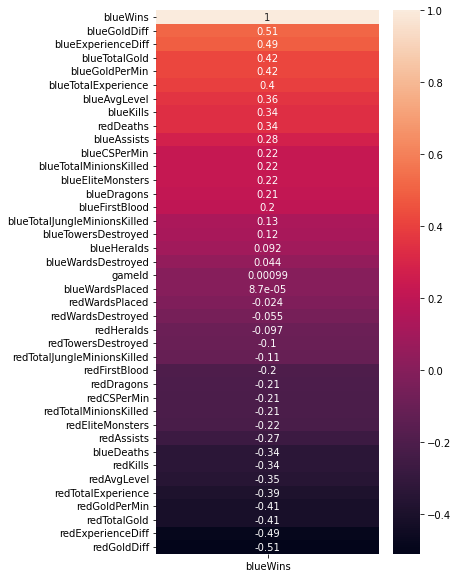

In [12]:
plt.figure(figsize=(5,10))
sns.heatmap(df.corr()[['blueWins']].sort_values(by='blueWins',ascending=False), annot=True);
# 승리와 다른 컬럼간에 상관관계를 알아봄

In [13]:
# EDA 해보면서 이상치 확인 및 제거

# 블루,레드팀 와드 설치/파괴 수 비교
ward_p = df[['blueWardsPlaced','redWardsPlaced']]
ward_d = df[['blueWardsDestroyed','redWardsDestroyed']]

fig1 = px.violin(ward_p, y=ward_p.columns, box=True, points="all",
               title = 'Wards Placed')

fig2 = px.violin(ward_d, y=ward_d.columns, box=True, points="all",
               title = 'Wards Destroyed')

fig1.update_layout(
    yaxis=dict(
        range=[5, 100]
    )
)

fig1.show()
fig2.show()
# 설치된 와드 수에 이상치가 존재하는 것으로 보인다.
# 8~30사이에 가장 많이 분포 되어 있고 50개 이상 설치한 와드수는 이상치로 처리한다.
# 파괴된 와드 수는 이상치 범위를 넘지않는다.

In [14]:
# 이상치 제거하기
drop_index = df[df['blueWardsPlaced']>=50].index
df.drop(drop_index, inplace=True)
drop_index1 = df[df['redWardsPlaced']>=50].index
df.drop(drop_index1, inplace=True)
df

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  \
0     4519157822         0               28                   2   
1     4523371949         0               12                   1   
2     4521474530         0               15                   0   
3     4524384067         0               43                   1   
5     4475365709         1               18                   0   
...          ...       ...              ...                 ...   
9871  4527715781         0               12                   2   
9873  4527878058         1               18                   2   
9874  4527873286         1               17                   2   
9876  4527713716         0               23                   1   
9878  4523772935         1               18                   0   

      blueFirstBlood  blueKills  blueDeaths  blueAssists  blueEliteMonsters  \
0                  1          9           6           11                  0   
1                  0          5           5            5                  0   
2                  0          7          11            4                  1   
3                  0          4           5            5                  1   
5                  0          5           3            6                  1   
...              ...        ...         ...          ...                ...   
9871               0          4           5            5                  2   
9873               1         12           6           13                  0   
9874               1          7           4            5                  1   
9876               0          6           7            5                  0   
9878               1          6           6            5                  0   

      blueDragons  ...  redTowersDestroyed  redTotalGold  redAvgLevel  \
0               0  ...                   0         16567      6.80000   
1               0  ...                   1         17620      6.80000   
2               1  ...                   0         17285      6.80000   
3               0  ...                   0         16478      7.00000   
5               1  ...                   0         15201      7.00000   
...           ...  ...                 ...           ...          ...   
9871            1  ...                   0         15858      6.80000   
9873            0  ...                   0         15934      6.60000   
9874            1  ...                   0         15246      6.80000   
9876            0  ...                   0         18319      7.40000   
9878            0  ...                   0         15339      6.80000   

      redTotalExperience  redTotalMinionsKilled  redTotalJungleMinionsKilled  \
0                  17047                    197                           55   
1                  17438                    240                           52   
2                  17254                    203                           28   
3                  17961                    235                           47   
5                  18060                    221                           59   
...                  ...                    ...                          ...   
9871               17873                    248                           48   
9873               17027                    197                           38   
9874               16498                    229                           34   
9876               19909                    261                           60   
9878               17379                    201                           46   

      redGoldDiff  redExperienceDiff  redCSPerMin  redGoldPerMin  
0            -643                  8     19.70000     1656.70000  
1            2908               1173     24.00000     1762.00000  
2            1172               1033     20.30000     1728.50000  
3            1321                  7     23.50000     1647.80000  
5            -698               -101     22.10000     1520.10000  
...           ..

In [15]:
# 승리할때와 패배할때의 feature간 분포 확인하기

win = df[df.blueWins ==1]   # 승리했을때
lose = df[df.blueWins ==0]  # 패배했을때

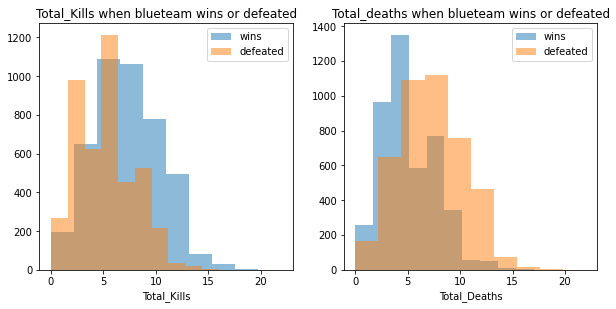

In [16]:
# kill/ death
# 승리,패배 시 킬과 데스의 분포 확인
fig = plt.figure(figsize=(10,10))

#킬
wins_kill = win['blueKills']
defeated_kill = lose['blueKills']

ax = fig.add_subplot(2,2,1)
plt.hist(wins_kill, alpha =0.5, label = 'wins')
plt.hist(defeated_kill, alpha =0.5, label = 'defeated')
ax.set_xlabel('Total_Kills')
ax.set_title('Total_Kills when blueteam wins or defeated')
plt.legend()

# 데스
wins_death = win['blueDeaths']
defeated_death = lose['blueDeaths']

ax = fig.add_subplot(2,2,2)
plt.hist(wins_death, alpha =0.5, label = 'wins')
plt.hist(defeated_death, alpha =0.5, label = 'defeated')
ax.set_xlabel('Total_Deaths')
ax.set_title('Total_deaths when blueteam wins or defeated')
plt.legend()

plt.show();
# 확실히 이겼을때 킬수가 더 많은쪽에 분포하고 데스는 적은쪽에 분포해있다.

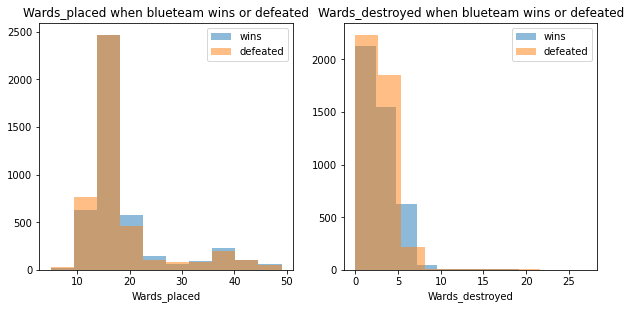

In [17]:
# 와드 설치/ 파괴
fig = plt.figure(figsize=(10,10))

# 설치
wins_ward_p = win['blueWardsPlaced']
defeated_ward_p = lose['blueWardsPlaced']

ax = fig.add_subplot(2,2,1)
plt.hist(wins_ward_p, alpha =0.5, label = 'wins')
plt.hist(defeated_ward_p, alpha =0.5, label = 'defeated')
ax.set_xlabel('Wards_placed')
ax.set_title('Wards_placed when blueteam wins or defeated')
plt.legend()

# 파괴
wins_ward_d = win['blueWardsDestroyed']
defeated_ward_d = lose['blueWardsDestroyed']

ax = fig.add_subplot(2,2,2)
plt.hist(wins_ward_d, alpha =0.5, label = 'wins')
plt.hist(defeated_ward_d, alpha =0.5, label = 'defeated')
ax.set_xlabel('Wards_destroyed')
ax.set_title('Wards_destroyed when blueteam wins or defeated')
plt.legend()

plt.show();
# 승리에 기여도가 클 줄 알았던 와드설치는 승패에 큰 영향없이 비슷한 수치를 보인다.

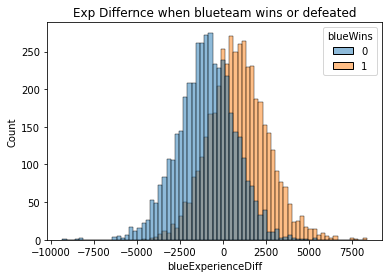

In [18]:
# 경험치 차이
sns.histplot(x='blueExperienceDiff',hue='blueWins',data=df);
plt.title("Exp Differnce when blueteam wins or defeated")
plt.show();

In [70]:
# 중립 몬스터 
col = ['blueEliteMonsters','blueDragons','blueHeralds','redEliteMonsters','redDragons','redHeralds']
tmp1 = df[col[0:3]].copy()
tmp1.columns = ['EliteMonsters','Dragons','Heralds']
tmp1['Side'] = 'Blue'
tmp2 = df[col[3:6]].copy()
tmp2.columns = ['EliteMonsters','Dragons','Heralds']
tmp2['Side'] = 'Red'

data = pd.concat([tmp1, tmp2], ignore_index = True)
data = data.groupby('Side').mean().reset_index()
data=pd.melt(data, id_vars=['Side'], value_vars=['EliteMonsters','Dragons','Heralds'])
data.columns = ['Side','NeutralGoals','Mean']

fig = px.bar(data, x="Side", y="Mean", color="Side",
             facet_col="NeutralGoals", title = 'Mean Neutral Goals per Side'
            )
fig.show()

In [19]:
# 데이터 분리
train, test =train_test_split(df, test_size=0.2, train_size=0.8,
                            stratify=df[target], random_state=2 )

train, val =train_test_split(train, test_size=0.2, train_size=0.8,
                            stratify=train[target], random_state=2 )

train.shape, val.shape, test.shape

((5591, 40), (1398, 40), (1748, 40))

### feature engineering
- 가장 많이들 사용하는 kda 지표 추가
- 중복적인 의미를 가지는(or 의미없는)특성 제거(다중공선성 피하기)
    > - blueGoldPerMin/redGoldPerMin : total/10
    > - redGoldDiff : -bluegoldDiff
    > - redtotalgold : bluetotalgold - bluegolddiff
    > - redtotalExp : bluetotalexp - blueExpDiff
    > - redExperienceDiff : -blueExpDiff
    > - redfirstblood : bluefirstblood 와 1,0
    > - redKills, redDeaths : blueDeaths, blueKills     
    > - gameId : 의미없는 feature
        
        - dragon,herald는 양팀 다 안잡는 경우가 있어서 킵
        - CsPerMin에는 정글 몹까지 포함되어 있기에 킵

In [20]:
train.reset_index(drop=True, inplace=True)   #  for문을 위해 인덱스 초기화
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [21]:
# 특성 공학
def feature_engineer(df):
    # 새로운 특성 kda = (kill+assist)/death
    # 이상치 제거과정에서 비어있는 인덱스가 발생 -> for문 에러
    
    blue =[]
    red =[]
    
    for i in range(len(df)):
        if df['blueDeaths'][i] != 0:
            blue.append(round((df['blueKills'][i] + df['blueAssists'][i])/df['blueDeaths'][i])) 
        else:
            blue.append(df['blueKills'][i] + df['blueAssists'][i])

    for x in range(len(df)):   
        if df['redDeaths'][x] == 0:
            red.append(df['redKills'][x] + df['redAssists'][x])
        else:
            red.append(round((df['redKills'][x] + df['redAssists'][x])/df['redDeaths'][x],2))

    df['blueKDA'] = blue
    df['redKDA'] = red
    
    # 같은 의미를 가지는 컬럼 제거
    dels = ['blueGoldPerMin','redGoldPerMin','redGoldDiff',
            'redTotalGold','redTotalExperience','redExperienceDiff',
            'redFirstBlood','redKills','redDeaths','gameId']
    df.drop(columns=dels, inplace=True)
      
    return df

train = feature_engineer(train)
val = feature_engineer(val)
test = feature_engineer(test)

print(train.shape, val.shape, test.shape)

features = train.drop(columns=[target]).columns            # 타겟 분리

# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

(5591, 32) (1398, 32) (1748, 32)


## 4) 머신러닝 방식 적용 및 교차검증

- 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
- 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
- 최종 모델에 관해 설명하세요.

### 로지스틱회귀모델, 랜덤포레스트모델, xgboost모델 비교

In [22]:
# 파이프라인 (로지스틱)
pipe_log = make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=2, max_iter=1000)        
) 

pipe_log.fit(X_train, y_train);
print('훈련 정확도: ', pipe_log.score(X_train, y_train))
print('검증세트 정확도', pipe_log.score(X_val, y_val))
# accuracy로 확인한 결과 0.72 정도의 정확도(balanced한 데이터에 효과적)
# 로지스틱회귀는 조정할 중요한 하이퍼파라미터가 없음

훈련 정확도:  0.7406546235020569
검증세트 정확도 0.7224606580829757


In [23]:
# 파이프라인 (랜덤포레스트)
pipe_ranf = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(random_state=2))       


pipe_ranf.fit(X_train, y_train);
print('훈련 정확도: ', pipe_ranf.score(X_train, y_train))
print('검증세트 정확도', pipe_ranf.score(X_val, y_val))

훈련 정확도:  1.0
검증세트 정확도 0.7217453505007153


In [24]:
# 파이프라인 (xgboost)
pipe_xgb = make_pipeline(
        StandardScaler(),
        XGBClassifier(random_state=2))        


pipe_xgb.fit(X_train, y_train);
print('훈련 정확도: ', pipe_xgb.score(X_train, y_train))
print('검증세트 정확도', pipe_xgb.score(X_val, y_val))

[11:32:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
훈련 정확도:  0.9760329100339832
검증세트 정확도 0.6938483547925608


### logisticregression의 경우는 괜찮게 정확도가 나왔지만 다른 모델들은 과적합된 것을 확인하였고 이를 방지하고 성능을 올리기위해 교차검증 및 하이퍼파라미터 튜닝 진행
- RandomizedSearchCV -> GridSearchCV

In [ ]:
# RandomForest
pipe_ranf1 = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(random_state=2)
        ) 

dists = {
    'randomforestclassifier__n_estimators': list(range(100,500,50)), # default가 100임
    'randomforestclassifier__max_depth':list(range(3,15)), 
    'randomforestclassifier__max_features': list(range(3,15)), # 값이 크면 트리들이 비슷해지고 가장 두드러진 특성에 맞게 예측
    'randomforestclassifier__min_samples_leaf': list(range(4,8))
}

# 모델명, 하이퍼파라미터 조정범위, 탐색횟수, 폴드 수, 평가방법, 진행상황표시, 시드
clf = RandomizedSearchCV(
    pipe_ranf1, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)

In [ ]:
pipe_ranf_best = clf.best_estimator_      # 최적의 하이퍼파라미터를 적용한 모델

print('훈련 정확도: ', pipe_ranf_best.score(X_train, y_train)) 
print('검증 정확도: ', pipe_ranf_best.score(X_val, y_val))

In [ ]:
# randomizedsearchCV를 통해 범위를 좁힌 후에 학습
dists = {
    'randomforestclassifier__n_estimators': list(range(300,500,50)),
    'randomforestclassifier__max_depth':list(range(4,7)), 
    'randomforestclassifier__max_features': list(range(10,15)), 
    'randomforestclassifier__min_samples_leaf': list(range(5,7))
}

grid_cv = GridSearchCV(
    pipe_ranf1, 
    param_grid=dists, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

grid_cv.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', grid_cv.best_params_)

In [ ]:
ranf_grid_best = grid_cv.best_estimator_      # 최적의 하이퍼파라미터를 적용

print('훈련 정확도: ', ranf_grid_best.score(X_train, y_train)) 
print('검증 정확도: ', ranf_grid_best.score(X_val, y_val))

- Boost parameter
        - learning rate : 일반적으로 0.01~0.2
        - min_child_weight : 추가 분기 결정기준(값이 너무 크면 underfitting)
        - max_depth : tree 깊이
        - subsample : 데이터중 샘플링(0.5~1)

In [ ]:
# XGBoost (정규화, 병렬처리, 결측치처리, 내장 CrossValidation의 장점)
xgb_1 = make_pipeline(
        StandardScaler(),
        XGBClassifier(random_state=10)
        ) 
dists = {
    'xgbclassifier__n_estimators': list(range(100,1000,100)),
    'xgbclassifier__max_depth':list(range(3,10)), 
    'xgbclassifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'xgbclassifier__min_child_weight':range(5,10),  # 모든 관측치의 최소 가중치합(너무 높으면 underfitting)
    'xgbclassifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9]
}

# 모델명, 하이퍼파라미터 조정범위, 탐색횟수, 폴드 수, 평가방법, 진행상황표시, 시드
clf1 = RandomizedSearchCV(
    xgb_1, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf1.fit(X_train, y_train);
#print('최적 하이퍼파라미터: ', clf1.best_params_)
clf1.best_params_, clf1.best_score_

In [ ]:
xgb1_best = clf1.best_estimator_      # 최적의 하이퍼파라미터를 적용한 모델

print('훈련 정확도: ', xgb1_best.score(X_train, y_train)) 
print('검증 정확도: ', xgb1_best.score(X_val, y_val))

In [ ]:
# grid search cv on xgboost
dists = {
    'xgbclassifier__n_estimators': list(range(100,300,50)),
    'xgbclassifier__max_depth': [3, 4], 
    'xgbclassifier__learning_rate': [0.001,0.005, 0.01],
    'xgbclassifier__min_child_weight': [5,6],
    'xgbclassifier__subsample': [0.6, 0.7, 0.8]
}

grid_cv1 = GridSearchCV(
    xgb_1, 
    param_grid=dists, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

grid_cv1.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', grid_cv1.best_params_)

In [ ]:
xgb_grid_best = grid_cv1.best_estimator_      # 최적의 하이퍼파라미터를 적용한 모델

print('훈련 정확도: ', xgb_grid_best.score(X_train, y_train)) 
print('검증 정확도: ', xgb_grid_best.score(X_val, y_val))

### RandomizedSearch 이후 범위를 축소시켜 GridSearchCV를 진행하였고 랜덤포레스트 모델에서는 더 과적합 된 결과가 나왔지만 XGBoost모델에서는 정확도도 향상되고 과적합을 방지하여 어느정도 일반화가 된 모델을 얻었다.

In [42]:
xgb_lol = XGBClassifier(n_estimators=250
                  , random_state=10
                  , n_jobs=-1
                  , max_depth=3
                  , learning_rate=0.005
                  , min_child_weight =6
                  , subsample=0.7
                 )
xgb_lol.fit(X_train, y_train)

[11:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
# permutation importance 순열중요도 

permuter = PermutationImportance(
    xgb_lol,
    scoring='accuracy', 
    n_iter=3,
    random_state=2
)

permuter.fit(X_val, y_val);

feature_names = X_train.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None,                    # 위에서 n개
    feature_names=feature_names
)

In [44]:
# 중요도가 -이거나 0인 특성 제외 -> 모델성능에 영향 없이 속도 개선

print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (5591, 31) (1398, 31)


In [45]:
minimum_importance = 0.0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape, X_test_selected.shape)

특성 삭제 후: (5591, 14) (1398, 14) (1748, 14)


In [46]:
eval_set = [(X_train_selected, y_train),
           (X_val_selected, y_val)]

xgb_lol.fit(X_train_selected, y_train)

print('훈련 정확도: ', xgb_lol.score(X_train_selected, y_train)) 
print('검증 정확도: ', xgb_lol.score(X_val_selected, y_val))

# 특성을 17개나 삭제하였지만 정확도가 오히려 좋아진 것을 확인할 수 있었다.(효율적)

[11:37:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
훈련 정확도:  0.7390448935789662
검증 정확도:  0.7281831187410587


- accuracy, precision, recall, f1-score확인
-  test셋에 모델을 적용한 결과도 baseline 모델보다는 좋은 정확도를 가진 모델임을 알 수 있다.(0.72)

In [47]:
print('테스트 정확도: ', xgb_lol.score(X_test_selected, y_test))
print(classification_report(y_test,xgb_lol.predict(X_test_selected)))

테스트 정확도:  0.7202517162471396
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       870
           1       0.73      0.71      0.72       878

    accuracy                           0.72      1748
   macro avg       0.72      0.72      0.72      1748
weighted avg       0.72      0.72      0.72      1748



- ROC_curve, AUC 확인

In [50]:
y_pred_proba = xgb_lol.predict_proba(X_test_selected)[:,1] 

fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_proba)

roc1 = pd.DataFrame({
    'FPR(Fall-out)': fpr1, 
    'TPRate(Recall)': tpr1, 
    'Threshold': thresholds1
})
roc1

FPR(Fall-out)  TPRate(Recall)  Threshold
0          0.00000         0.00000    1.82033
1          0.00115         0.00683    0.82033
2          0.00115         0.00797    0.82010
3          0.00115         0.01025    0.82007
4          0.00115         0.01139    0.81995
..             ...             ...        ...
656        0.97356         0.99886    0.17754
657        0.97586         0.99886    0.17733
658        0.97931         0.99886    0.17728
659        0.98161         0.99886    0.17716
660        1.00000         1.00000    0.17689

[661 rows x 3 columns]

In [51]:
# 최적의 threshold로 바꿔주면 성능이 올라갈 것 -> accuracy 변화는 없지만 precision,recall값 향상됨
optimal_idx1 = np.argmax(tpr1 - fpr1)
optimal_threshold1 = thresholds1[optimal_idx1]

print('best_threshold:', optimal_threshold1)

best_threshold: 0.49044383


In [52]:
# 최적의 threshold 적용
predicted_test = (y_pred_proba>= optimal_threshold1).astype('int')
print(classification_report(y_test,predicted_test))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       870
           1       0.73      0.72      0.72       878

    accuracy                           0.72      1748
   macro avg       0.72      0.72      0.72      1748
weighted avg       0.72      0.72      0.72      1748



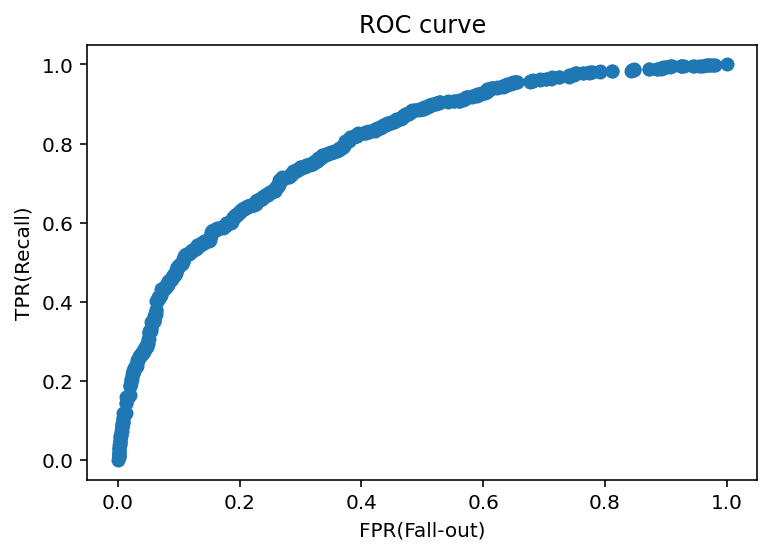

In [53]:
fig = plt.figure()
plt.scatter(fpr1, tpr1)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.show()

In [54]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC_score:", auc_score)                      # 1에 가까울수록 좋다

AUC_score: 0.8002683737857722


## 5) 머신러닝 모델 해석

- 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
- 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?

### xgboost model 특징 중요도

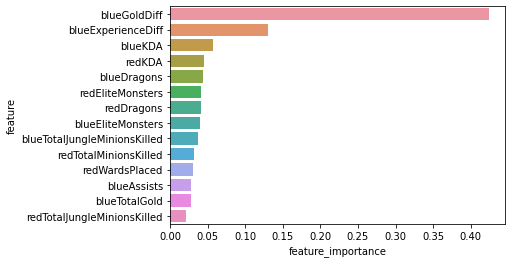

In [35]:
data = {"feature":X_train_selected.columns, 'feature_importance': xgb_lol.feature_importances_}
df_importance = pd.DataFrame(data)
df_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
sns.barplot(df_importance['feature_importance'], df_importance['feature']);

### PDP

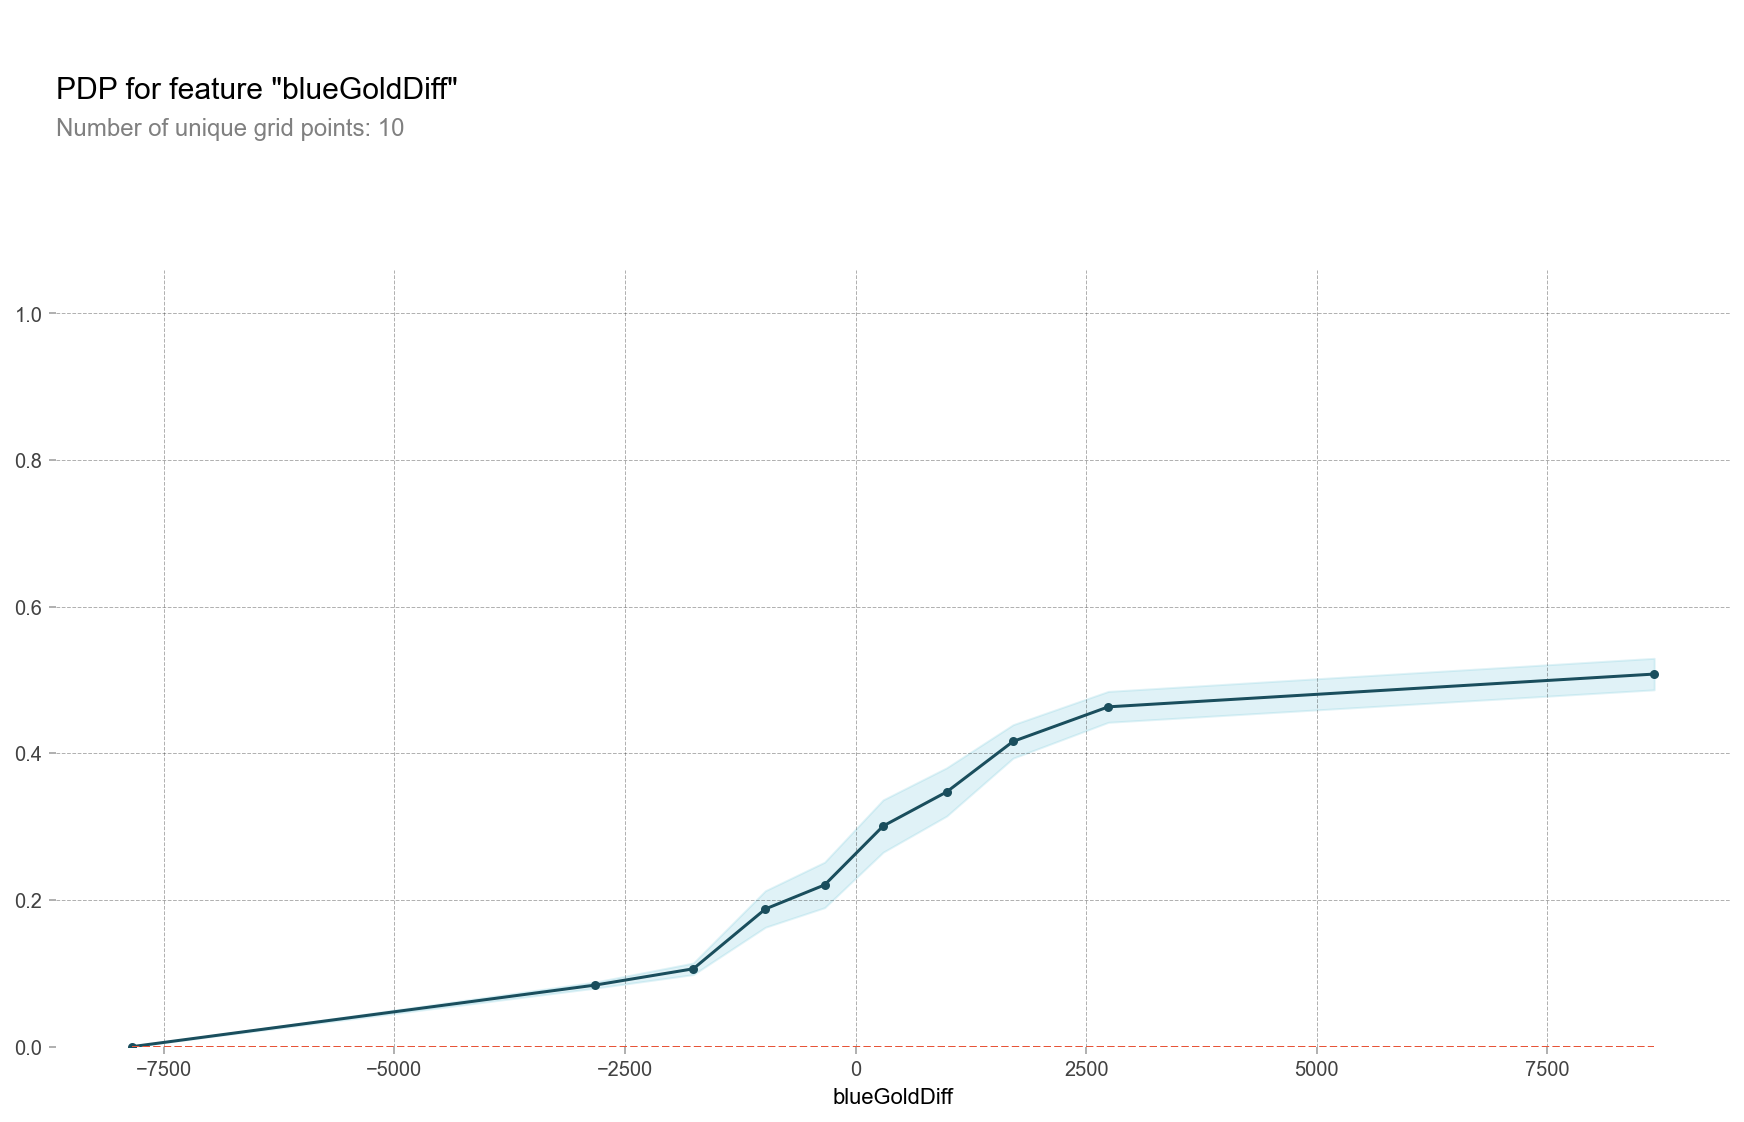

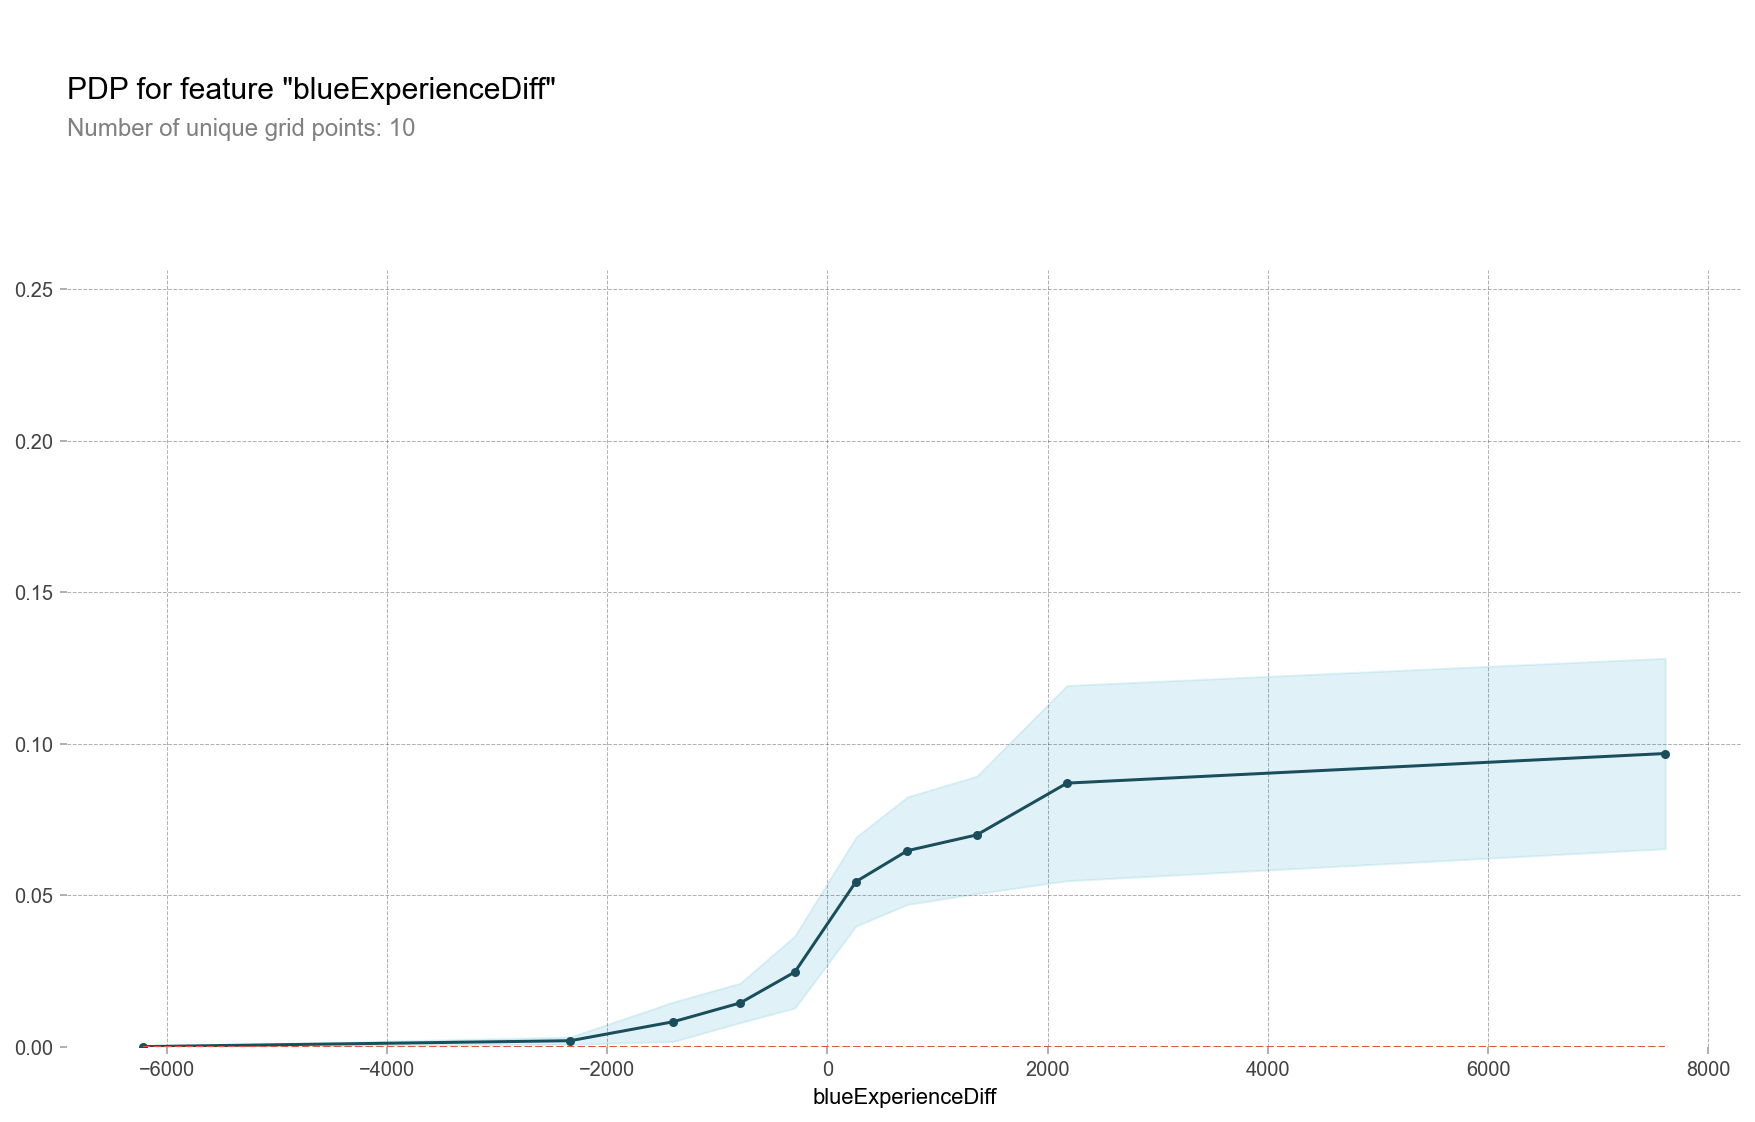

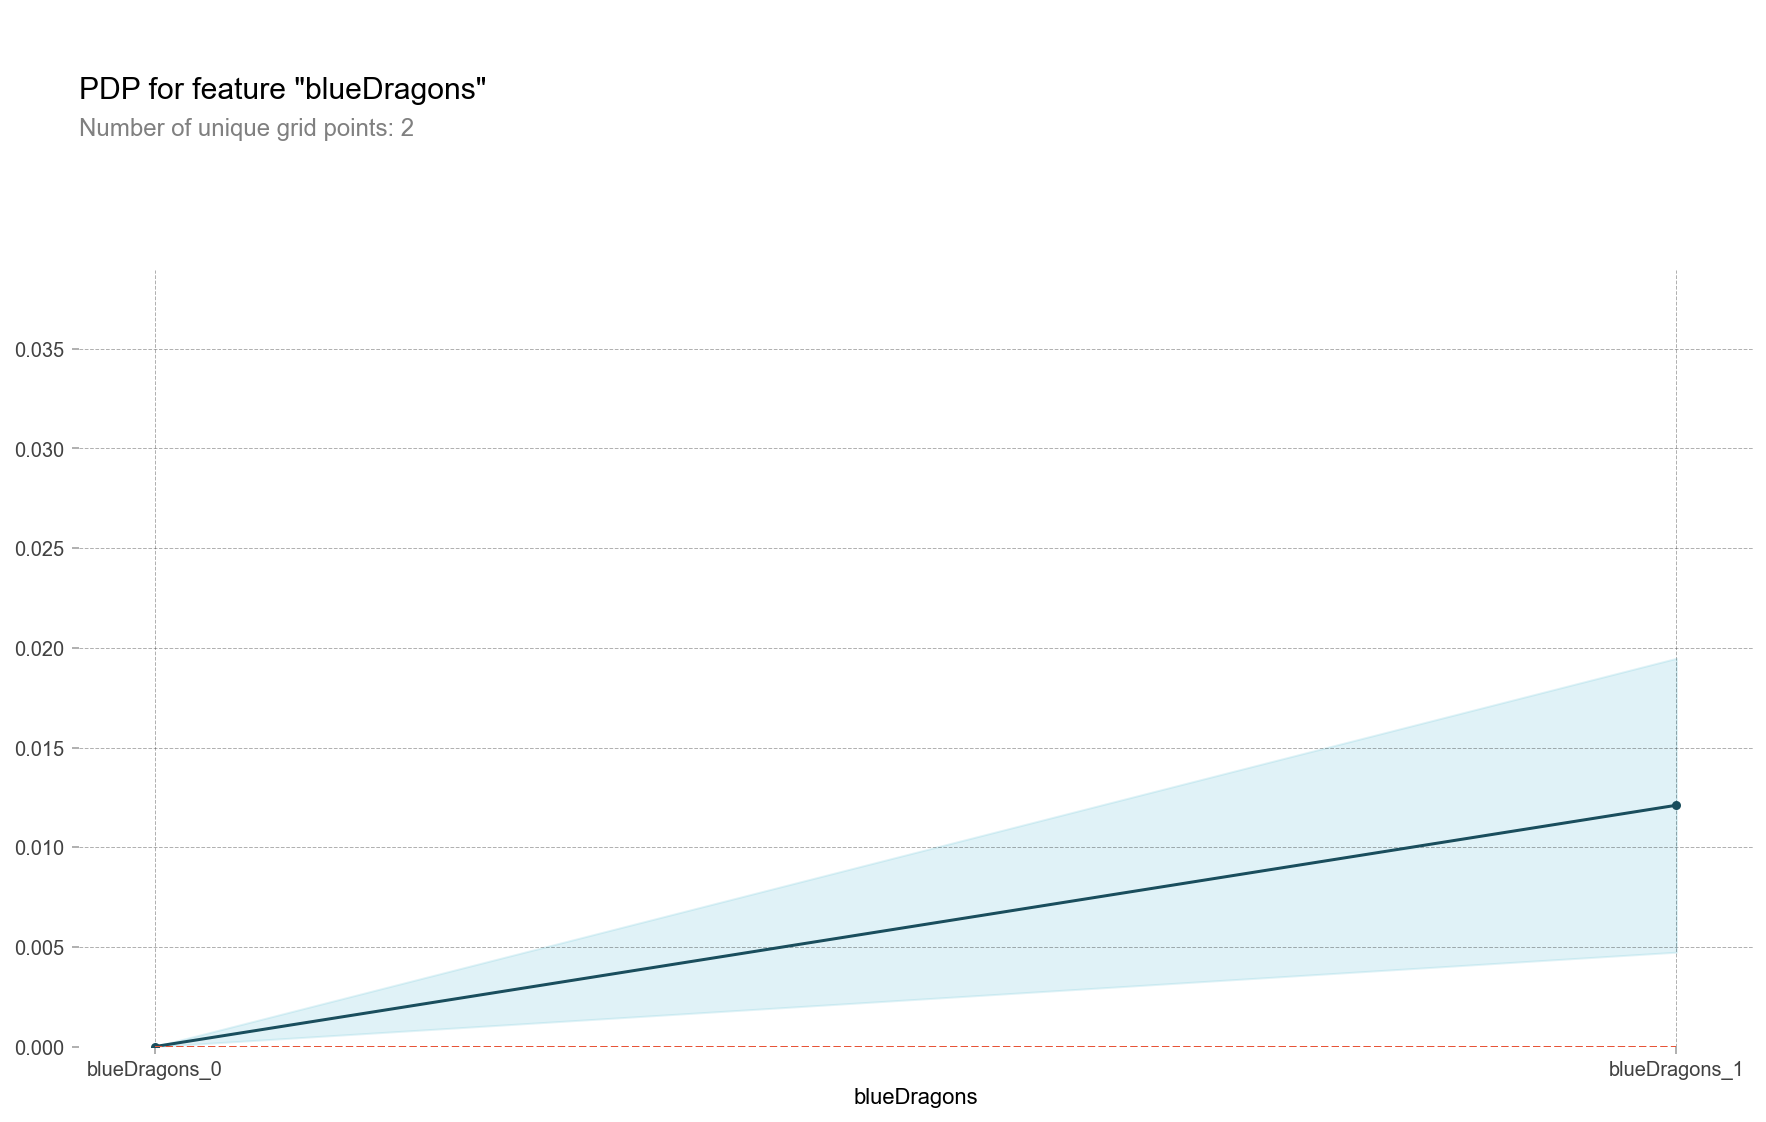

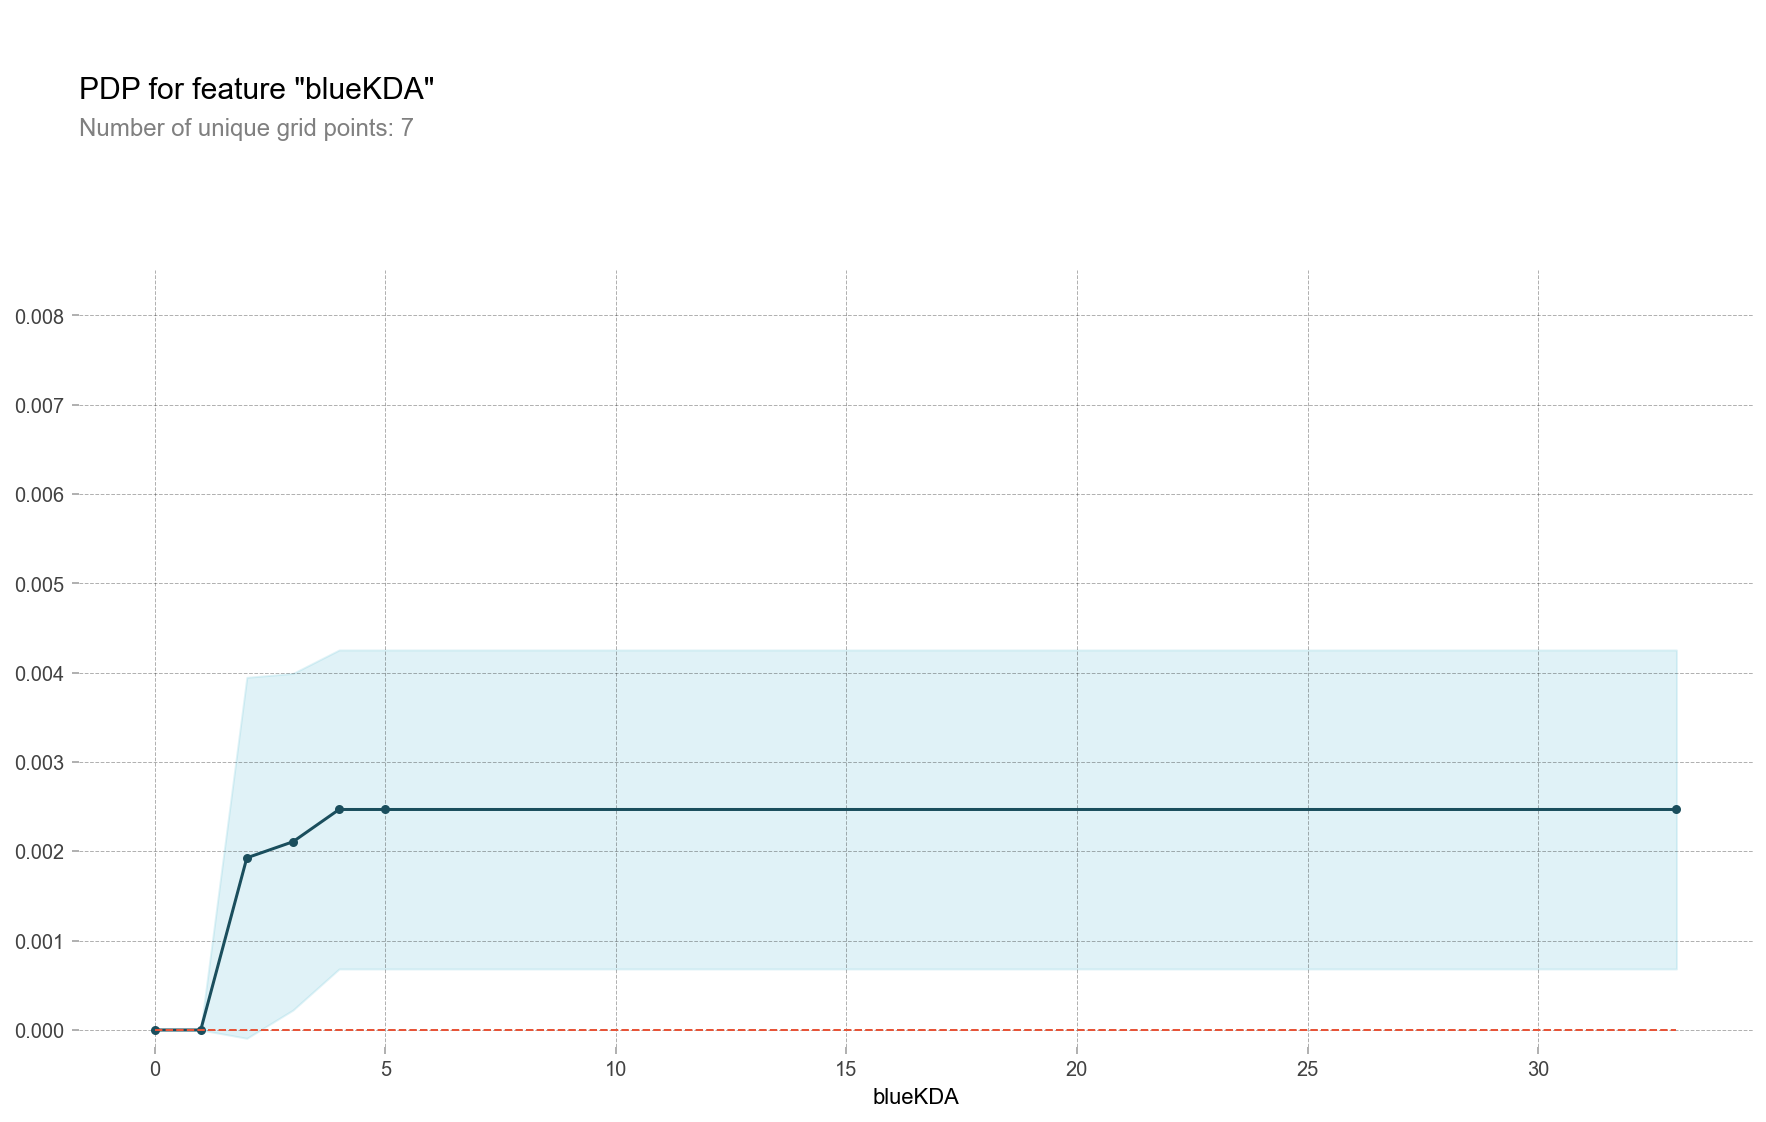

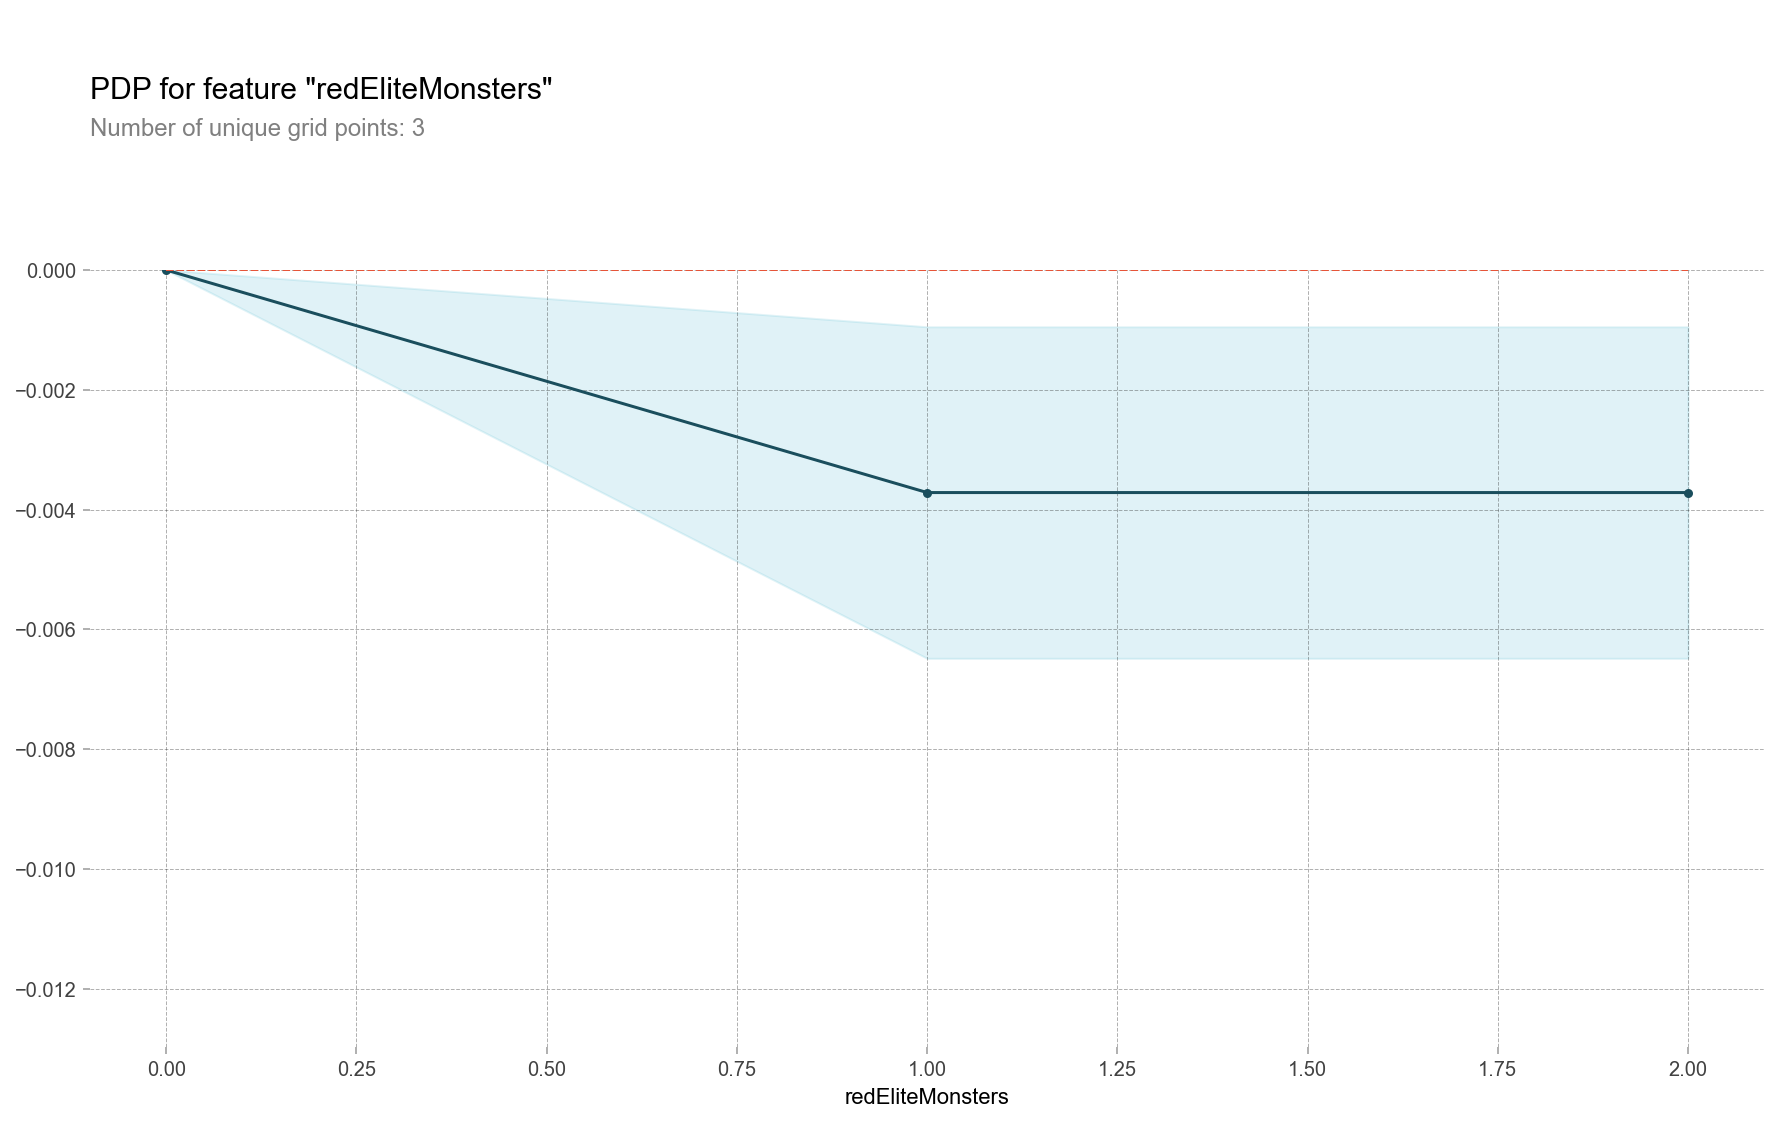

In [36]:
plt.rcParams['figure.dpi'] = 144

columns = ['blueGoldDiff','blueExperienceDiff','blueDragons','blueKDA','redEliteMonsters'] 
# 상위 5개 features

for x in columns:
  isolated1 = pdp_isolate(
      model=xgb_lol, 
      dataset=X_val_selected, 
      model_features=X_val_selected.columns, 
      feature=x
  )

  pdp_plot(isolated1, feature_name=x);

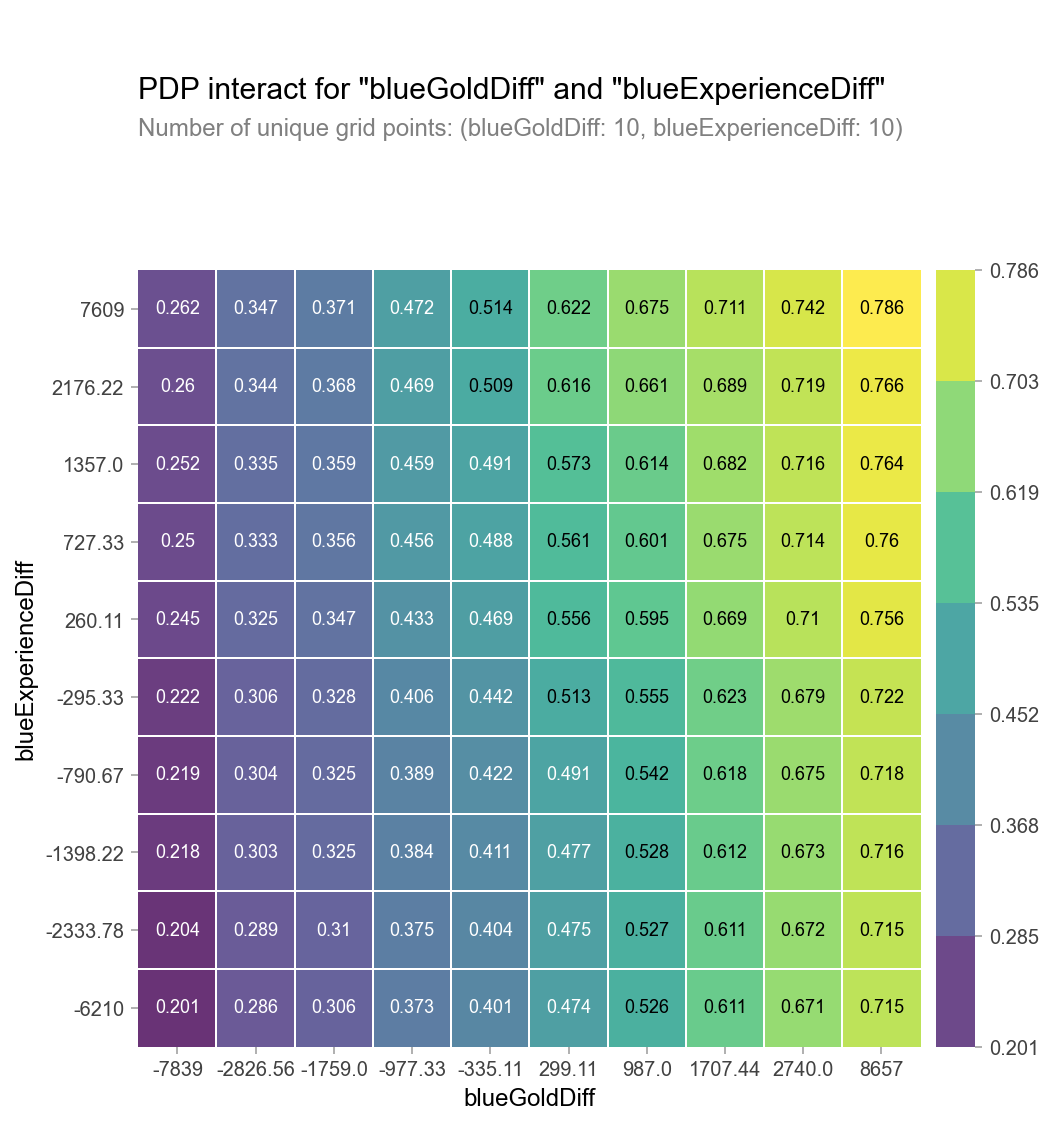

In [37]:
features2 = ['blueGoldDiff', 'blueExperienceDiff']   

interaction = pdp_interact(
    model=xgb_lol, 
    dataset=X_val_selected,
    model_features=X_val_selected.columns, 
    features=features2
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features2);


### SHAP

In [38]:
row = X_test_selected.iloc[[1]]  # 임의의 row

xgb_lol.predict(row)  # 모델의 예측값

explainer = shap.TreeExplainer(xgb_lol)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)
# goldDiff와 ExpDiff가 타겟값을 올리는데, redDragons가 값을 낮추는데 영향을 주었다.

In [60]:
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [61]:
print('승리 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')
print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

승리 예측에 대한 Positive 요인 Top 3 입니다:
1. blueGoldDiff : 1294.0
2. blueExperienceDiff : 453.0
3. redKDA : 0.7


Negative 요인 Top 3 입니다:
1. redDragons : 1.0
2. blueDragons : 0.0
3. redEliteMonsters : 1.0


In [39]:
shap_values = explainer.shap_values(X_train_selected.iloc[:100])

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_train_selected.iloc[:100]
)# 여러샘플들을 통해 특성들이 타겟에 어떻게 영향을 주는지 확인

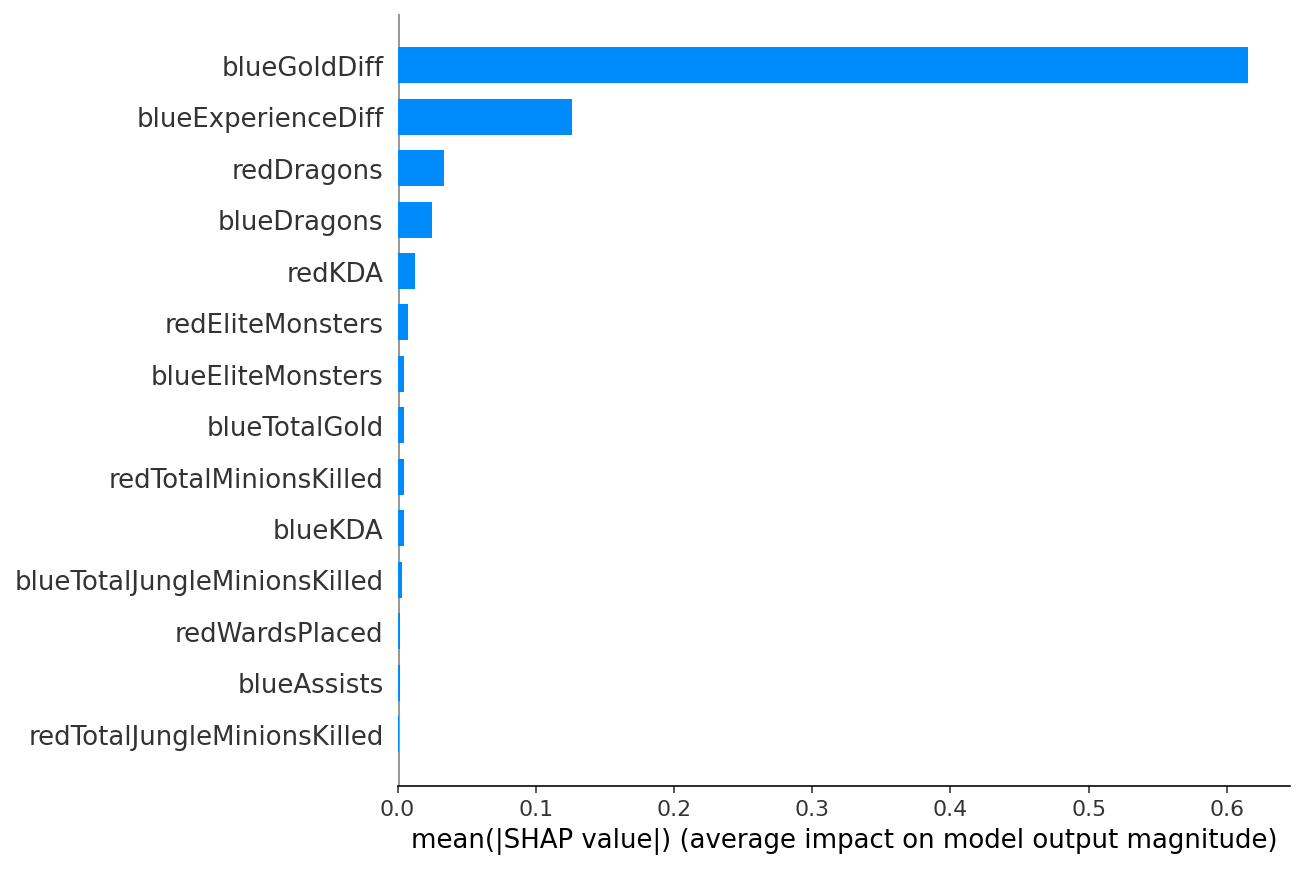

In [40]:
shap.summary_plot(shap_values, X_train_selected, plot_type='bar')

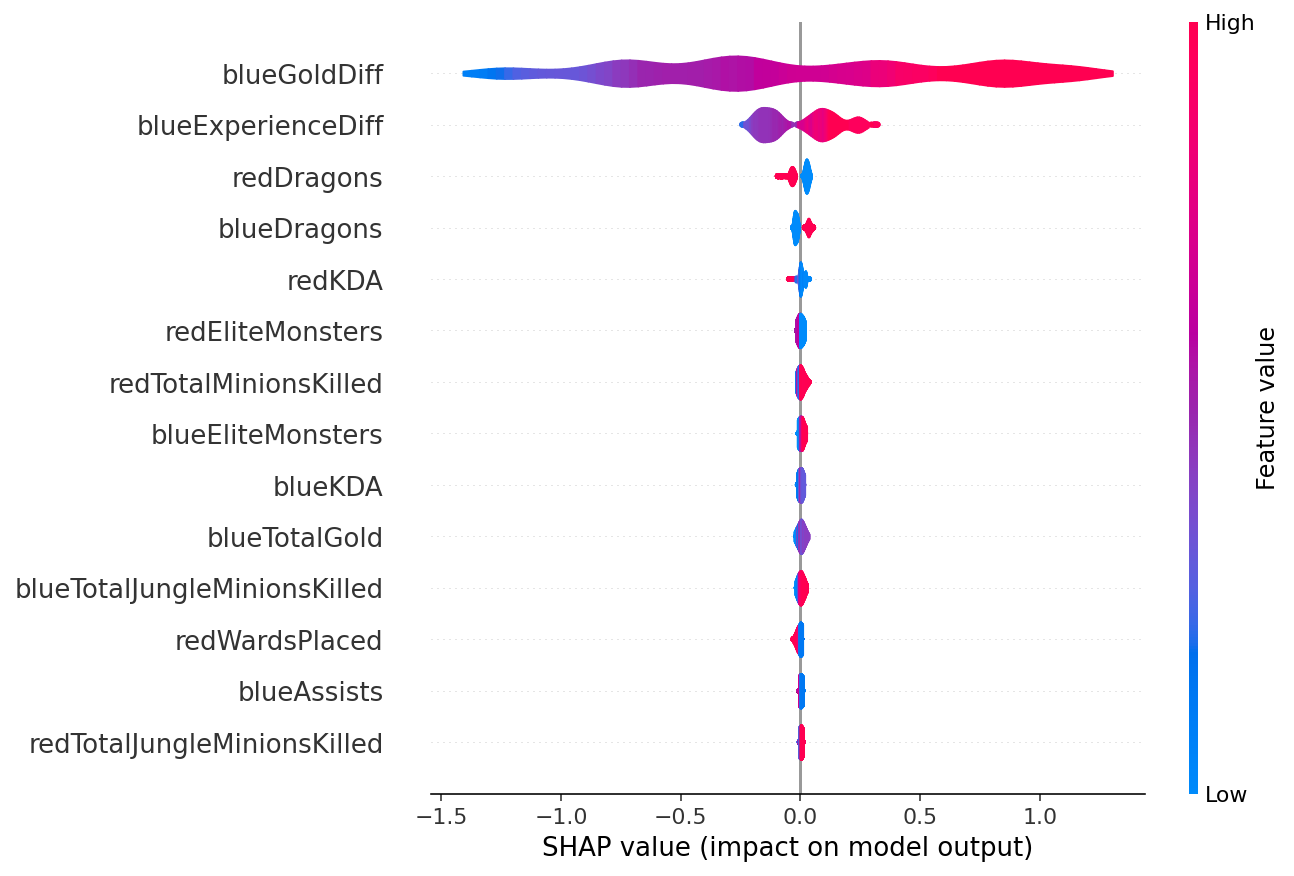

In [41]:
explainer_lol = shap.TreeExplainer(xgb_lol)   
shap_values_lol = explainer_lol.shap_values(X_train_selected)
shap.summary_plot(shap_values_lol, X_train_selected, plot_type="violin");
# 골드차이량이 승리의 유무에 가장 큰 영향을 주는 것 같다.